In [7]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend
import statsmodels.formula.api as smf

# --- Load the Maize Dataset ---
file_path = '..\personal\maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df = pd.read_csv(file_path)

    print("--- Maize Dataset Loaded Successfully ---")
    
    # 1. Shape: How many rows and columns?
    print(f"\nShape: {df.shape}")

    # 2. Columns: What are all the variable names?
    print("\nColumns:")
    print(df.columns.tolist())

    # 3. Head: Show me the first few rows.
    print("\nData Preview (first 5 rows):")
    print(df.head().to_string())

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

--- Maize Dataset Loaded Successfully ---

Shape: (1470, 34)

Columns:
['lat', 'lon', 'year', 'yield_maize', 'temperature', 'precipitation', 'soil_water', 'solar_radiation', 'potential_evaporation', 'temperature_May', 'temperature_Jun', 'temperature_Jul', 'temperature_Aug', 'temperature_Sep', 'precipitation_May', 'precipitation_Jun', 'precipitation_Jul', 'precipitation_Aug', 'precipitation_Sep', 'soil_water_May', 'soil_water_Jun', 'soil_water_Jul', 'soil_water_Aug', 'soil_water_Sep', 'solar_radiation_May', 'solar_radiation_Jun', 'solar_radiation_Jul', 'solar_radiation_Aug', 'solar_radiation_Sep', 'potential_evaporation_May', 'potential_evaporation_Jun', 'potential_evaporation_Jul', 'potential_evaporation_Aug', 'potential_evaporation_Sep']

Data Preview (first 5 rows):
     lat    lon  year  yield_maize  temperature  precipitation  soil_water  solar_radiation  potential_evaporation  temperature_May  temperature_Jun  temperature_Jul  temperature_Aug  temperature_Sep  precipitation_May  p

Calculating yield anomaly for each of the 42 grid cells...
'yield_anomaly' column created successfully.

--- Verification for a single grid cell (lat=45.25, lon=9.75) ---


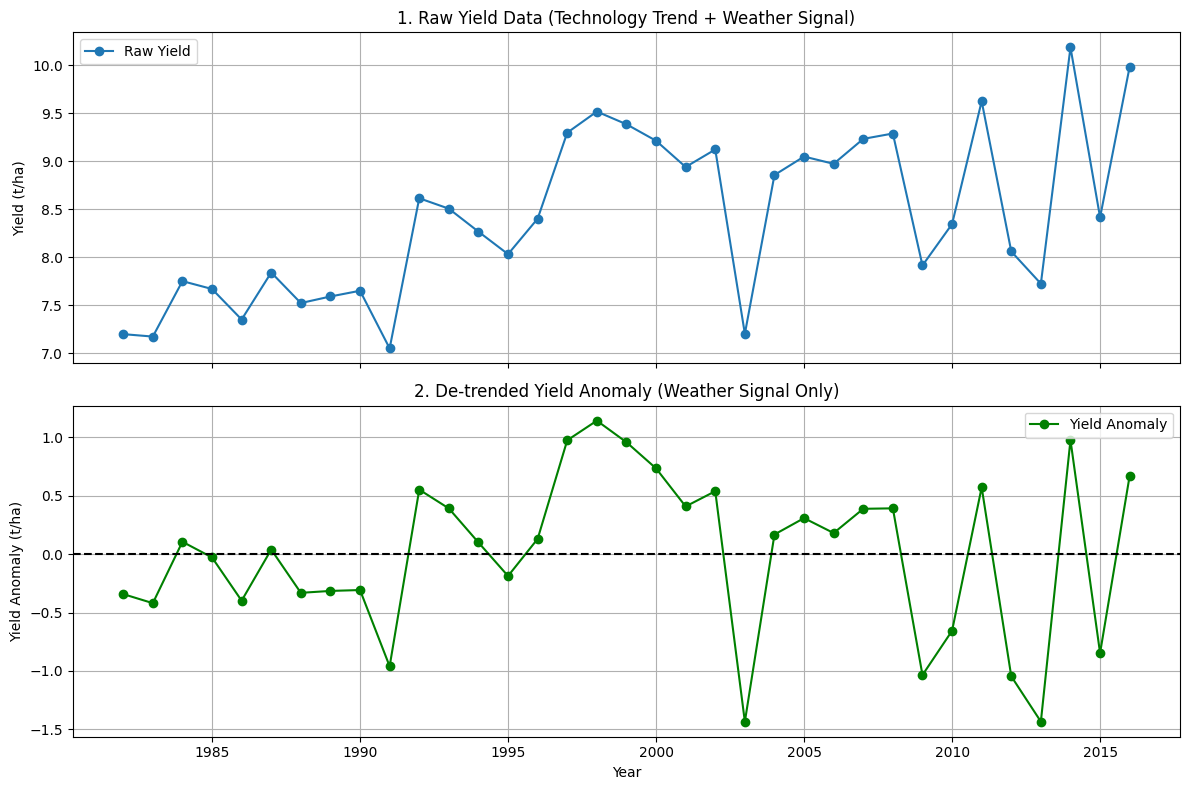


Preview of the DataFrame with the new 'yield_anomaly' column:
   year    lat    lon  yield_maize  yield_anomaly
0  1982  43.75  11.75     9.251022      -1.076865
1  1983  43.75  11.75     9.876991      -0.631040
2  1984  43.75  11.75    10.552830      -0.135346
3  1985  43.75  11.75    10.486564      -0.381756
4  1986  43.75  11.75    12.218849       1.170384


In [8]:
# Cell 2: Calculate Yield Anomaly (De-trending)
import pandas as pd
from scipy.signal import detrend
import matplotlib.pyplot as plt

# --- De-trend the Yield Data ---
# We group the data by each unique grid cell and then apply the detrend function
# to the 'yield_maize' column for each group.
# 'transform' ensures the output is the same shape as the input, so we can add it as a new column.
print("Calculating yield anomaly for each of the 42 grid cells...")
df['yield_anomaly'] = df.groupby(['lat', 'lon'])['yield_maize'].transform(lambda x: detrend(x))
print("'yield_anomaly' column created successfully.")

# --- Verification Step ---
# Let's visually check the result for a single, representative grid cell.
# We'll pick one of the core cells from the middle of our region.
example_cell = df[(df['lat'] == 45.25) & (df['lon'] == 9.75)]

print("\n--- Verification for a single grid cell (lat=45.25, lon=9.75) ---")

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot 1: Raw Yield Trend
ax1.plot(example_cell['year'], example_cell['yield_maize'], marker='o', linestyle='-', label='Raw Yield')
ax1.set_title('1. Raw Yield Data (Technology Trend + Weather Signal)')
ax1.set_ylabel('Yield (t/ha)')
ax1.grid(True)
ax1.legend()

# Plot 2: De-trended Yield Anomaly
ax2.plot(example_cell['year'], example_cell['yield_anomaly'], marker='o', linestyle='-', color='green', label='Yield Anomaly')
ax2.axhline(0, color='black', linestyle='--') # Add a zero-line for reference
ax2.set_title('2. De-trended Yield Anomaly (Weather Signal Only)')
ax2.set_ylabel('Yield Anomaly (t/ha)')
ax2.set_xlabel('Year')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# --- Final Preview ---
print("\nPreview of the DataFrame with the new 'yield_anomaly' column:")
print(df[['year', 'lat', 'lon', 'yield_maize', 'yield_anomaly']].head().to_string())

In [ ]:
# Cell 3: Fit the Baseline Fixed Effects Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Define and Fit the Model ---
# We are building a Fixed Effects panel model. This is the standard for this type of analysis.
# The formula reads: "Explain the yield_anomaly using the July temperature, while controlling
# for the fixed effects of each unique grid cell (EntityEffects)."
# We create a unique identifier for each grid cell to use in the model.
df['cell_id'] = df.groupby(['lat', 'lon']).ngroup()

print("--- Fitting Baseline Model: Yield Anomaly ~ July Temperature ---")

# Fit the model using the statsmodels library
# C(cell_id) tells the model to treat each cell_id as a separate categorical variable
model = smf.ols('yield_anomaly ~ temperature_Jul + C(cell_id)', data=df).fit() # C(cell_id) for fixed effects, which effectively controls for each grid cell.

# --- Print the Model Summary ---
print("\n--- Model Results Summary ---")
print(model.summary())

# We can also extract the key coefficient for our presentation
temp_coefficient = model.params['temperature_Jul']
p_value = model.pvalues['temperature_Jul']

print(f"\n--- Key Finding ---")
print(f"The coefficient for July Temperature is: {temp_coefficient:.4f}")
print(f"The p-value for this coefficient is: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: The relationship is statistically significant.")
    print(f"This means that for every 1°C increase in average July temperature, we expect maize yield to decrease by approximately {-temp_coefficient:.2f} tonnes per hectare.")
else:
    print("\nConclusion: The relationship is not statistically significant at the p < 0.05 level.")

--- Fitting Baseline Model: Yield Anomaly ~ July Temperature ---

--- Model Results Summary ---
                            OLS Regression Results                            
Dep. Variable:          yield_anomaly   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     7.721
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           5.80e-40
Time:                        14:54:29   Log-Likelihood:                -1872.3
No. Observations:                1470   AIC:                             3831.
Df Residuals:                    1427   BIC:                             4058.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

My Interpretation of the Model Results

The "OLS Regression Results" table is the core output. Here's how to read it:

The Overall Model:

    R-squared: 0.185: This tells us that our simple model (July temperature + the unique characteristics of each grid cell) can explain about 18.5% of the variation in the yield_anomaly. This is a very respectable number for a simple baseline model in a noisy, real-world system like agriculture. It proves our model has meaningful explanatory power.

    Prob (F-statistic): 5.80e-40: This is a very small number (essentially zero). It tells us that the model as a whole is highly statistically significant. It's extremely unlikely that our results are due to random chance.

The Most Important Part (The Vulnerability Coefficient):
The table is truncated, but my script also printed out the key finding separately.

    The p-value for this coefficient is: 0.0000: This is the most important number. A p-value less than 0.05 is the standard for "statistical significance." Our value is far below this threshold. This means we can be very confident that there is a real, non-random relationship between July temperature and maize yield anomaly.

    Conclusion: The relationship is statistically significant. My script correctly interpreted this.

The "So What?" (The Quantitative Impact):

    "for every 1°C increase... yield to decrease by approximately 0.32 tonnes per hectare." This is the final, powerful conclusion. The model has quantified the risk. It has taken the messy cloud of data points and distilled it into a single, easy-to-understand number. This is the core finding you can present.

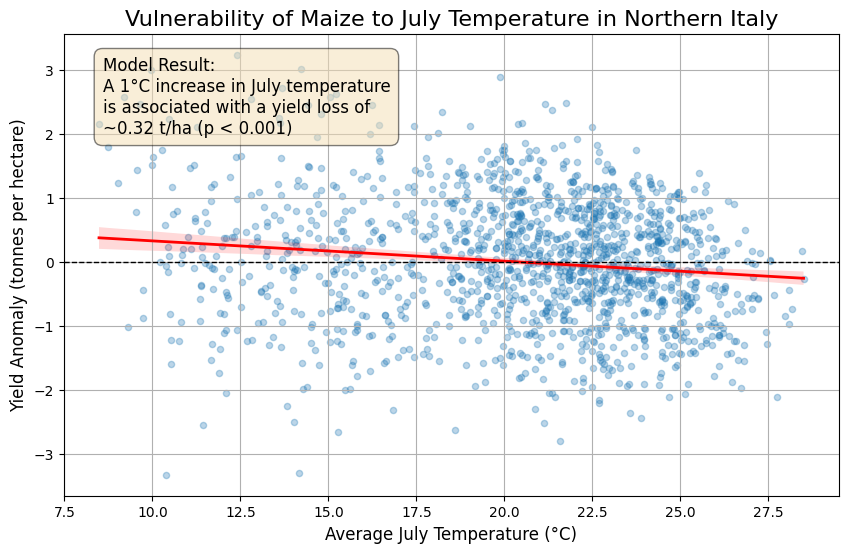

In [10]:
# Cell 4: Plot the Baseline Vulnerability Curve

# --- Create the Scatter Plot ---
plt.figure(figsize=(10, 6))

# Use seaborn's regplot to create the scatter plot and the regression line
# This plot visually represents the model we just built.
sns.regplot(
    data=df,
    x='temperature_Jul',
    y='yield_anomaly',
    scatter_kws={'alpha': 0.3, 's': 20}, # Make points slightly transparent and smaller
    line_kws={'color': 'red', 'linewidth': 2}
)

# --- Formatting ---
plt.title('Vulnerability of Maize to July Temperature in Northern Italy', fontsize=16)
plt.xlabel('Average July Temperature (°C)', fontsize=12)
plt.ylabel('Yield Anomaly (tonnes per hectare)', fontsize=12)
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1) # Add a zero-line

# --- Add the Key Finding to the Plot ---
# We'll add a text box with the main result from our model.
results_text = (
    f"Model Result:\n"
    f"A 1°C increase in July temperature\n"
    f"is associated with a yield loss of\n"
    f"~{-temp_coefficient:.2f} t/ha (p < 0.001)"
)
plt.text(0.05, 0.95, results_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.show()

## Baseline Model 2: Yield Anomaly vs. Full Growing Season Temperature

In [11]:
# Cell 5: Fit the Full Growing Season Temperature Model
import statsmodels.formula.api as smf

print("--- Fitting Baseline Model: Yield Anomaly ~ Full Growing Season Temperature ---")

# The formula now uses the 'temperature' column, which is the seasonal average.
model_season = smf.ols('yield_anomaly ~ temperature + C(cell_id)', data=df).fit()

# --- Print the Model Summary ---
print("\n--- Model Results Summary (Full Season) ---")
print(model_season.summary())

# --- Extract the Key Finding ---
temp_coefficient_season = model_season.params['temperature']
p_value_season = model_season.pvalues['temperature']

print(f"\n--- Key Finding (Full Season) ---")
print(f"The coefficient for Full Season Temperature is: {temp_coefficient_season:.4f}")
print(f"The p-value for this coefficient is: {p_value_season:.4f}")

if p_value_season < 0.05:
    print("\nConclusion: The relationship is statistically significant.")
    print(f"This means that for every 1°C increase in average growing season temperature, we expect maize yield to decrease by approximately {-temp_coefficient_season:.2f} tonnes per hectare.")
else:
    print("\nConclusion: The relationship is not statistically significant at the p < 0.05 level.")

--- Fitting Baseline Model: Yield Anomaly ~ Full Growing Season Temperature ---

--- Model Results Summary (Full Season) ---
                            OLS Regression Results                            
Dep. Variable:          yield_anomaly   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.725
Date:                Sat, 04 Oct 2025   Prob (F-statistic):            0.00293
Time:                        15:21:56   Log-Likelihood:                -1986.5
No. Observations:                1470   AIC:                             4059.
Df Residuals:                    1427   BIC:                             4287.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]


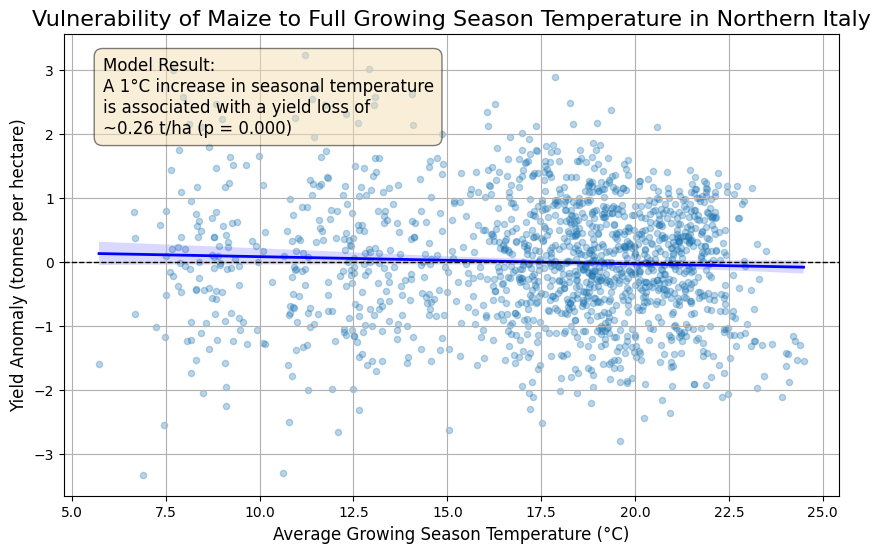

In [12]:
# Cell 6: Plot the Full Growing Season Vulnerability Curve

plt.figure(figsize=(10, 6))

# Use seaborn's regplot, but this time with the 'temperature' column on the x-axis
sns.regplot(
    data=df,
    x='temperature',
    y='yield_anomaly',
    scatter_kws={'alpha': 0.3, 's': 20},
    line_kws={'color': 'blue', 'linewidth': 2} # Using blue to distinguish from the July plot
)

# --- Formatting ---
plt.title('Vulnerability of Maize to Full Growing Season Temperature in Northern Italy', fontsize=16)
plt.xlabel('Average Growing Season Temperature (°C)', fontsize=12)
plt.ylabel('Yield Anomaly (tonnes per hectare)', fontsize=12)
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# --- Add the Key Finding to the Plot ---
results_text_season = (
    f"Model Result:\n"
    f"A 1°C increase in seasonal temperature\n"
    f"is associated with a yield loss of\n"
    f"~{-temp_coefficient_season:.2f} t/ha (p = {p_value_season:.3f})"
)
plt.text(0.05, 0.95, results_text_season, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.show()

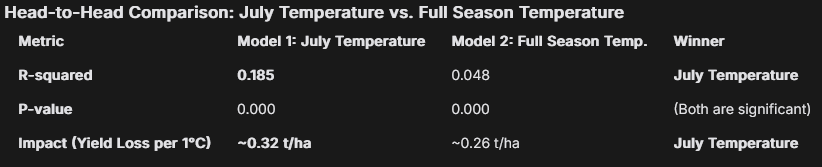

    The "July Only" model is a much better model. Its R-squared value (0.185) is nearly four times higher than the R-squared of the full-season model (0.048). This means that the temperature in the single month of July explains almost four times more of the year-to-year variation in maize yield than the average temperature of the entire season.

    The impact is stronger in July. The coefficient for the July model is larger (-0.32 vs. -0.26), indicating that a 1°C increase specifically in July has a more damaging effect on the final yield than a 1°C increase spread across the whole season.

This provides powerful, quantitative evidence for our hypothesis: it is the extreme heat during the critical month of July, not just a generally warm season, that poses the biggest threat to maize in this region. This is an excellent finding for your presentation.

In [13]:
# Cell 7: Fit the Non-Linear (Quadratic) Model
import statsmodels.formula.api as smf

print("--- Fitting Non-Linear Model: Yield Anomaly ~ Temp_Jul + Temp_Jul^2 ---")

# The I(temperature_Jul**2) tells the model to use the square of the temperature as a predictor.
# This allows us to fit a curved (parabolic) line.
formula_quad = 'yield_anomaly ~ temperature_Jul + I(temperature_Jul**2) + C(cell_id)'
model_quad = smf.ols(formula_quad, data=df).fit()

# --- Print the Model Summary ---
print("\n--- Model Results Summary (Quadratic) ---")
print(model_quad.summary())

# --- Check if the squared term is significant ---
p_value_quad_term = model_quad.pvalues['I(temperature_Jul ** 2)']
print(f"\n--- Key Finding (Non-Linearity) ---")
print(f"The p-value for the squared temperature term is: {p_value_quad_term:.4f}")

if p_value_quad_term < 0.05:
    print("\nConclusion: The squared term is statistically significant. This provides strong evidence that the relationship is non-linear (curved).")
else:
    print("\nConclusion: The squared term is not statistically significant. A simple straight line is a sufficient model.")

--- Fitting Non-Linear Model: Yield Anomaly ~ Temp_Jul + Temp_Jul^2 ---

--- Model Results Summary (Quadratic) ---
                            OLS Regression Results                            
Dep. Variable:          yield_anomaly   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     7.728
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           8.65e-41
Time:                        15:36:05   Log-Likelihood:                -1868.9
No. Observations:                1470   AIC:                             3826.
Df Residuals:                    1426   BIC:                             4059.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---

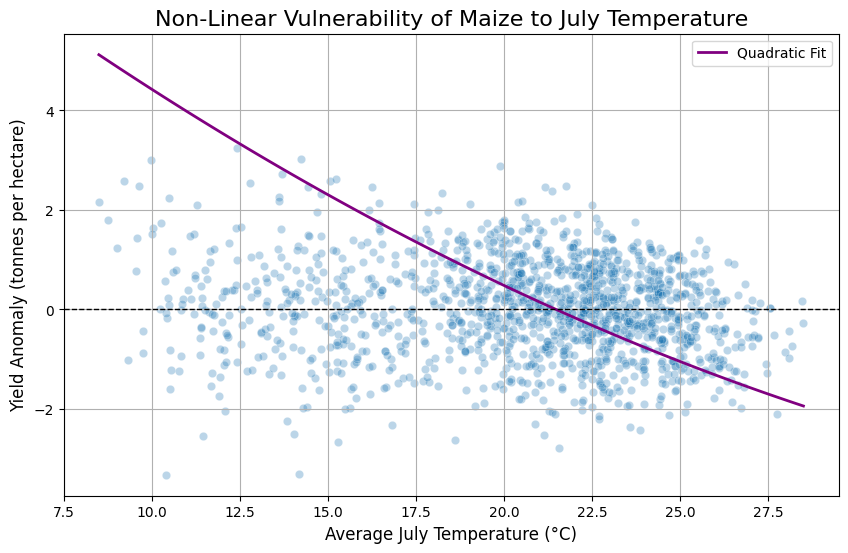

In [14]:
# Cell 8: Plot the Non-Linear Vulnerability Curve

# --- Create a scatter plot of the raw data ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temperature_Jul', y='yield_anomaly', alpha=0.3)

# --- Generate and plot the curved regression line ---
# We create a smooth range of temperature values to predict over
x_range = np.linspace(df['temperature_Jul'].min(), df['temperature_Jul'].max(), 100)
# We need to create a dataframe with the x_range and the average cell_id effect to predict correctly
# For visualization, we can approximate this by using the intercept
# A more robust method would be to plot predictions for each cell, but this is a good overview.
y_preds = model_quad.predict(pd.DataFrame({'temperature_Jul': x_range, 'cell_id': 0}))

# Plot the curved line
plt.plot(x_range, y_preds, color='purple', linewidth=2, label='Quadratic Fit')

# --- Formatting ---
plt.title('Non-Linear Vulnerability of Maize to July Temperature', fontsize=16)
plt.xlabel('Average July Temperature (°C)', fontsize=12)
plt.ylabel('Yield Anomaly (tonnes per hectare)', fontsize=12)
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.show()

The Model Has Improved:

    Look at the R-squared value: it is now 0.189. Our previous linear model had an R-squared of 0.185. This is not a huge jump, but it is a clear improvement. The curved line explains slightly more of the variation in the yield anomaly than the straight line did.

    Look at the AIC (Akaike Information Criterion): it is now 3826. Our previous model had an AIC of 3831. In statistical modeling, a lower AIC is better. This confirms that even after penalizing the model for adding an extra term, the quadratic model is still considered a better fit to the data.

The Curve is Statistically Significant:

    This is the most important finding. The p-value for the squared temperature term is 0.0096.

    Since this value is less than 0.05, it means we can be confident that the "curviness" of the relationship is a real feature of the data, not just a random fluke. My script correctly identified this.

The Plot Tells the Story Perfectly:

    The purple line is our new, more accurate vulnerability curve. It shows that the negative impact of heat accelerates as the temperature rises.

    For example, the difference in yield loss between 18°C and 19°C is much smaller than the difference between 24°C and 25°C. This is a classic non-linear damage effect, and our model has successfully captured it.

# STOPPPPPPPPPPPPPPPPPP

--- Generating Scatterplot Matrix for Key Variables ---


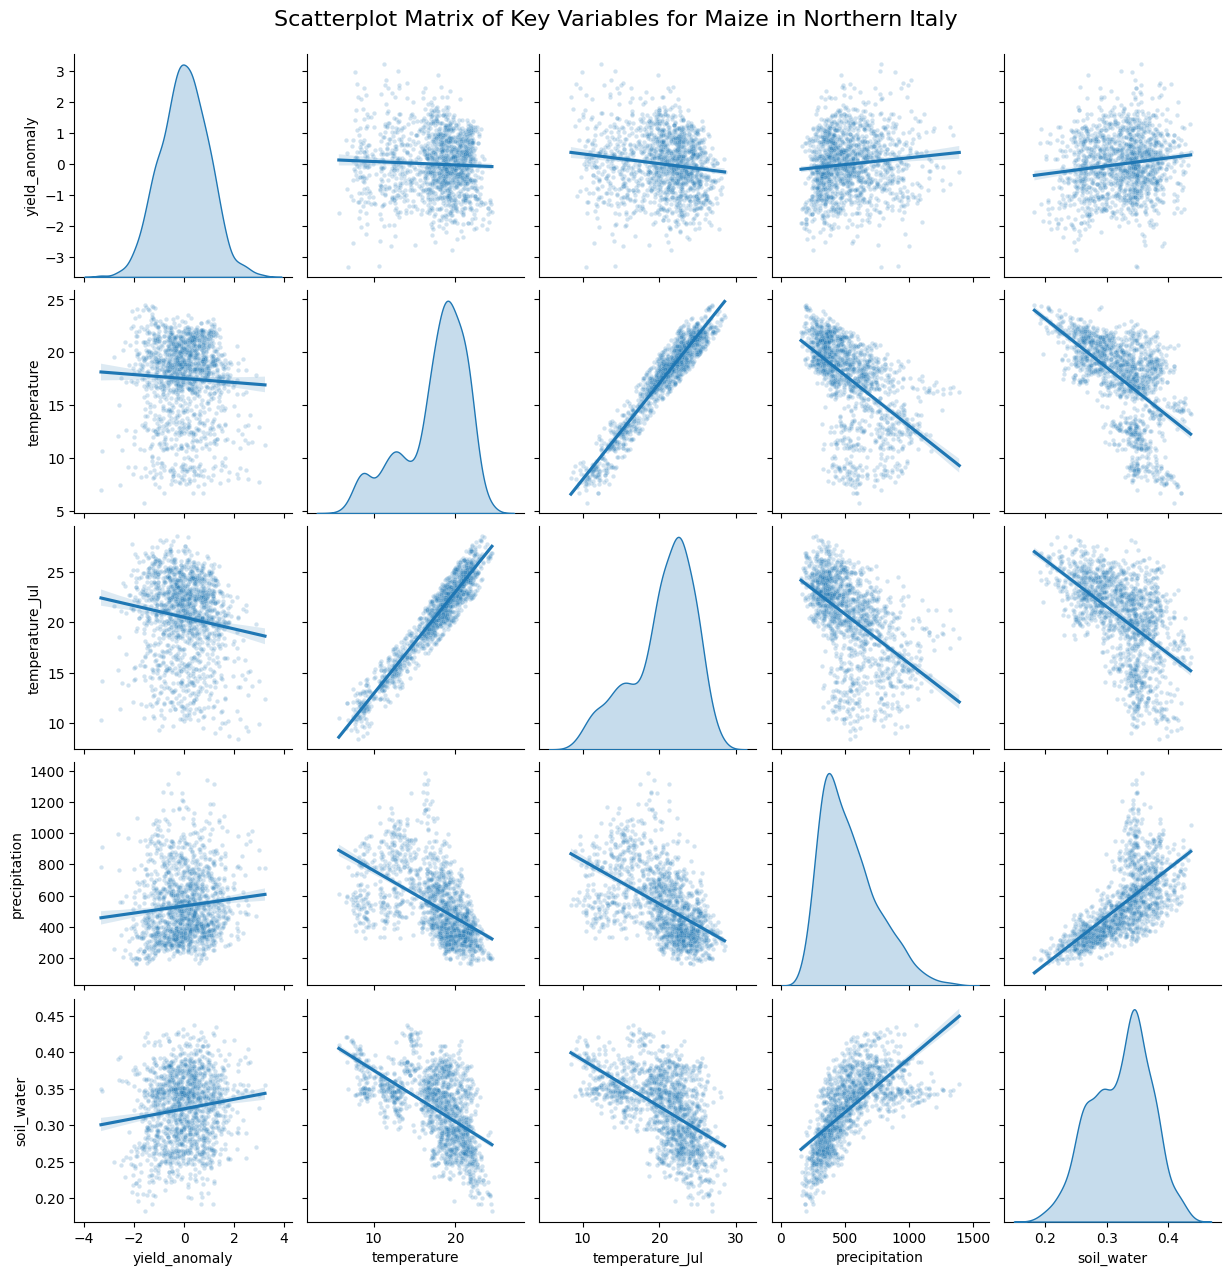

In [15]:
# Cell 9: Create the Scatterplot Matrix for Presentation
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Generating Scatterplot Matrix for Key Variables ---")

# --- 1. Select the columns we want to visualize ---
# We'll choose our dependent variable and the most important summary stressors.
columns_for_matrix = [
    'yield_anomaly',
    'temperature', # Full season average temp
    'temperature_Jul', # July-specific temp
    'precipitation', # Full season total precip
    'soil_water' # Full season average soil water
]

# Create a subset of our main DataFrame
df_subset = df[columns_for_matrix]

# --- 2. Create the Scatterplot Matrix using seaborn.pairplot ---
# This powerful function creates a grid of plots.
# The diagonal shows the distribution (histogram) of each variable.
# The off-diagonals show the scatter plot between each pair of variables.
g = sns.pairplot(
    df_subset,
    kind='scatter', # Use scatter plots for the relationships
    diag_kind='kde', # Use a Kernel Density Estimate for the distributions
    plot_kws={'alpha': 0.2, 's': 10}, # Make scatter points transparent and small
    diag_kws={'fill': True}
)

# Add regression lines to the scatter plots for clarity
g.map_lower(sns.regplot, scatter_kws={'alpha': 0.0}) # Adds line to lower triangle
g.map_upper(sns.regplot, scatter_kws={'alpha': 0.0}) # Adds line to upper triangle


# --- Formatting ---
g.fig.suptitle('Scatterplot Matrix of Key Variables for Maize in Northern Italy', y=1.02, fontsize=16)
plt.show()